<a href="https://colab.research.google.com/github/kayaisacat/IAI5101_Assignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A: Supervised Learning

In [107]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from pandas.plotting import scatter_matrix

In [108]:
# from google.colab import drive
# drive.mount('/content/drive')

In [109]:
# Load the data
#df=pd.read_csv('drive/My Drive/Colab Notebooks/concrete.csv')
df=pd.read_csv('/Users/yuting/Desktop/Assignment2/concrete.csv')

(1030, 9)

In [164]:
# check the initial five records
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,1.000000,0.000000,0.0,0.201702,0.384384,0.755756,0.135135,0.522022,0.997038
1,1.000000,0.000000,0.0,0.201702,0.384384,0.822322,0.135135,0.522022,0.934263
2,0.717718,0.752753,0.0,0.969970,0.000000,0.260761,0.000000,0.974474,0.648511
3,0.717718,0.752753,0.0,0.969970,0.000000,0.260761,0.000000,1.000000,0.667668
4,0.271271,0.723724,0.0,0.689690,0.000000,0.567568,0.764765,0.983984,0.736737


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               1030 non-null   float64
 1   BlastFurnaceSlag     1030 non-null   float64
 2   FlyAsh               1030 non-null   float64
 3   Water                1030 non-null   float64
 4   Superplasticizer     1030 non-null   float64
 5   CoarseAggregate      1030 non-null   float64
 6   FineAggregate        1030 non-null   float64
 7   Age                  1030 non-null   int64  
 8   CompressiveStrength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


## I. EDA :

### Univariate Analysis: 
#### 1.Build a histogram to show the distribution and central values of all the variables

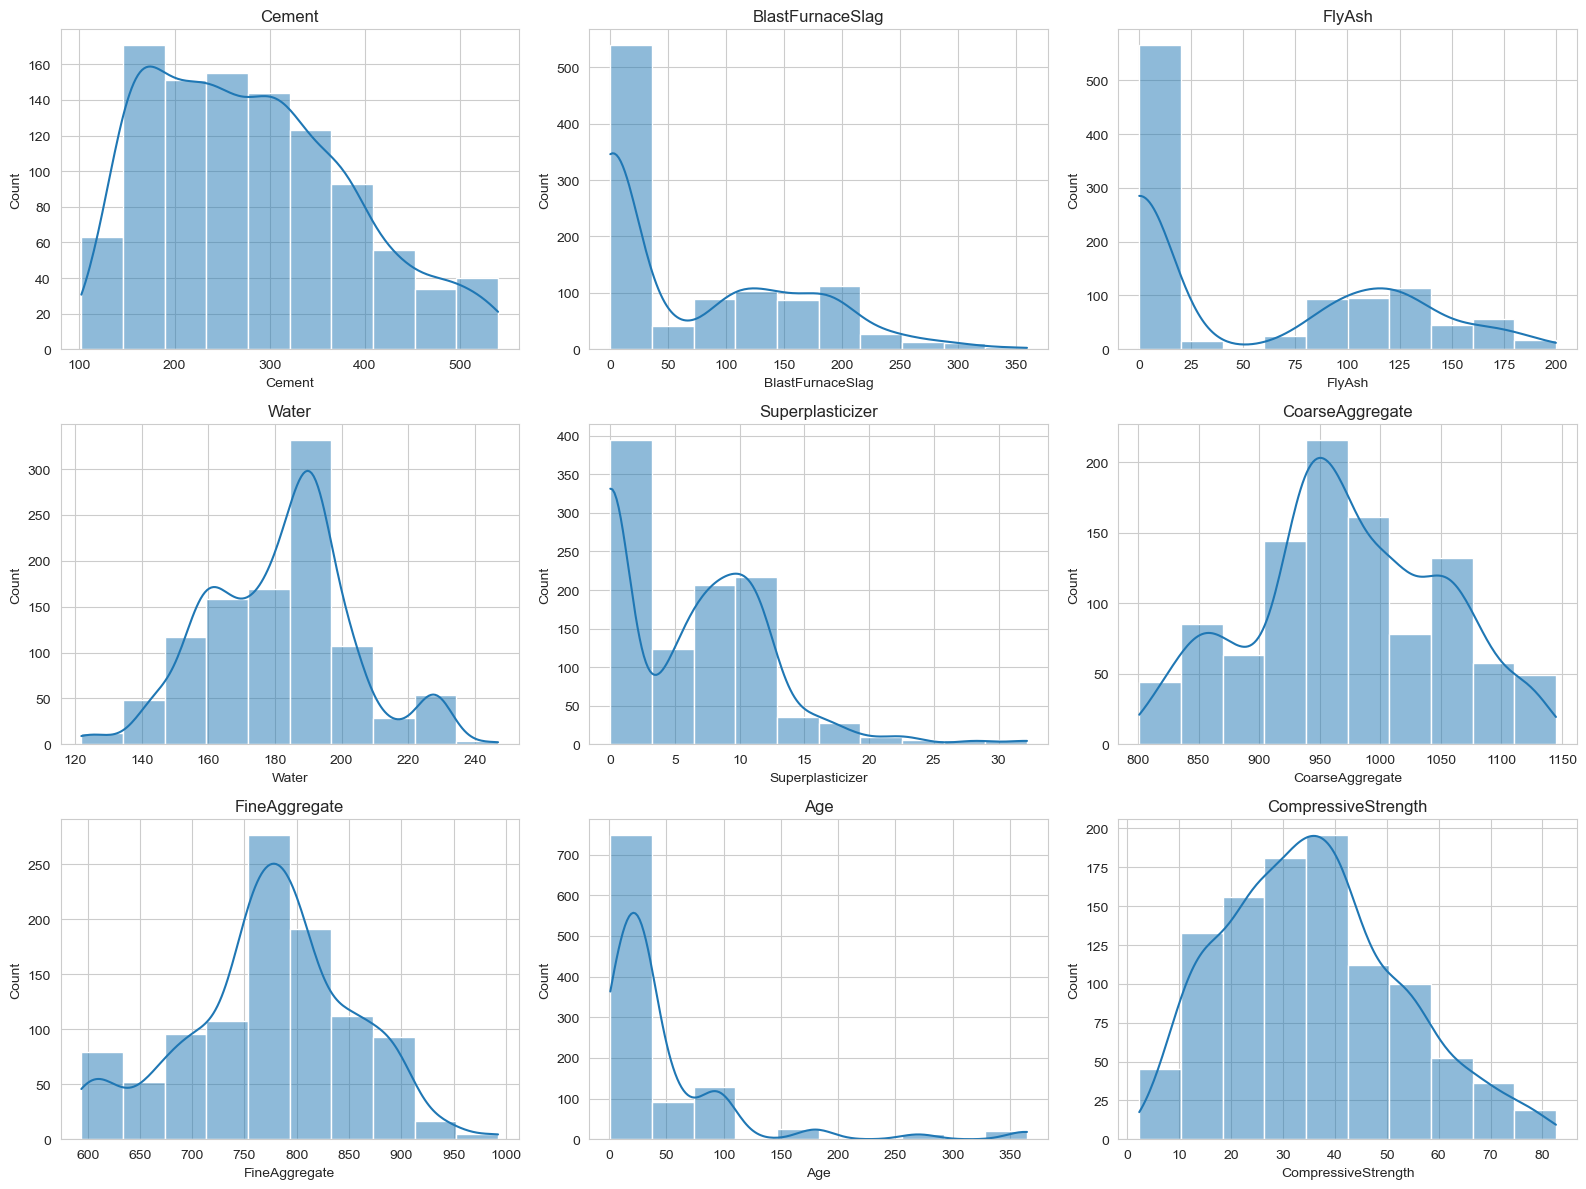

In [138]:
# Set up the figure
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

# Loop through each variable and create a histogram
for i, var in enumerate(df.columns):
    row = i // 3
    col = i % 3
    sns.histplot(data=df[var], bins=10, kde=True, ax=axs[row][col])
    axs[row][col].set_title(var)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [119]:
# Get central values of all variables
central_values = df.describe().loc[['mean', '50%'], :]
central_values = central_values.T
print(central_values)

                           mean      50%
Cement               281.167864  272.900
BlastFurnaceSlag      73.895825   22.000
FlyAsh                54.188350    0.000
Water                181.567282  185.000
Superplasticizer       6.204660    6.400
CoarseAggregate      972.918932  968.000
FineAggregate        773.580485  779.500
Age                   45.662136   28.000
CompressiveStrength   35.817961   34.445


#### 2. Use a boxplot to determine if there are outliers in the variables

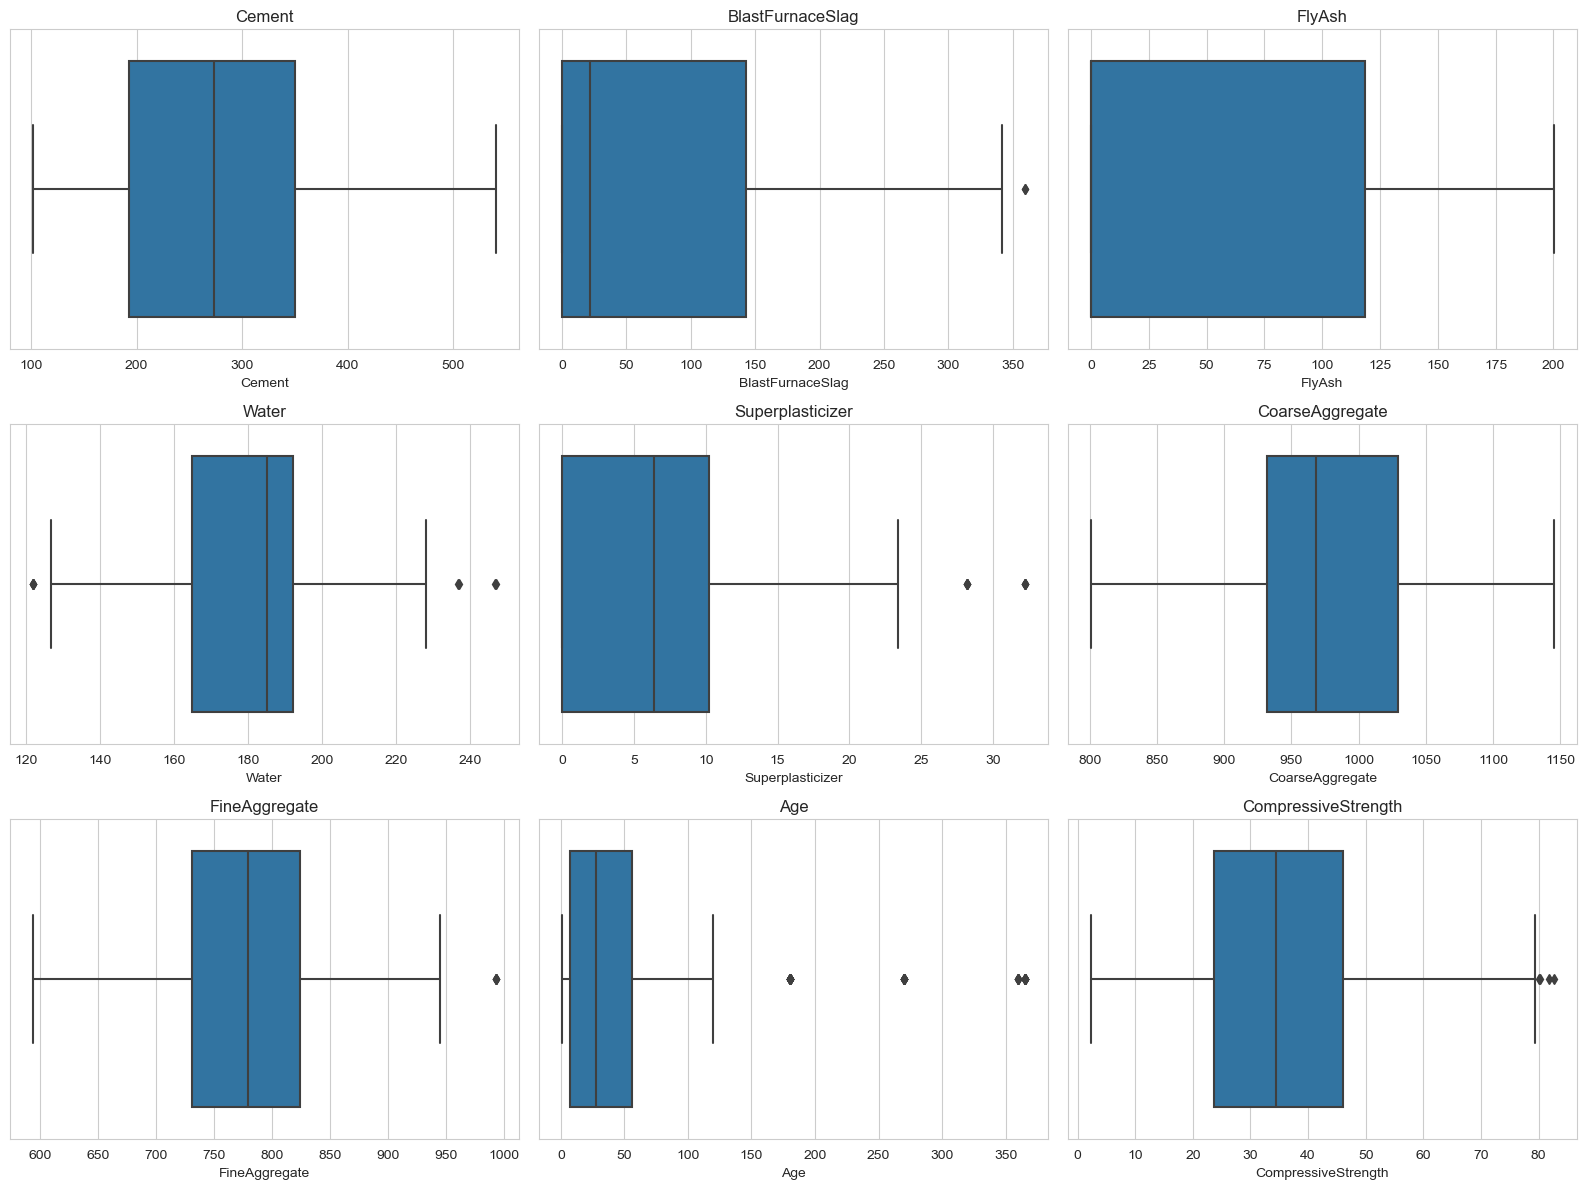

In [139]:
# Set up the figure
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

# Loop through each variable and create a boxplot
for i, var in enumerate(df.columns):
    row = i // 3
    col = i % 3
    sns.boxplot(x=df[var], ax=axs[row][col])
    axs[row][col].set_title(var)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Blast Furnace Slag, Water , Super plasticizer, Fine Aggregate, Age, Compressive Strength
have outliners in dataset. 

### Multivariate Analysis:
#### 1. Use a pair plot to determine the relationship and degree of relation between independent variables and between independent variables

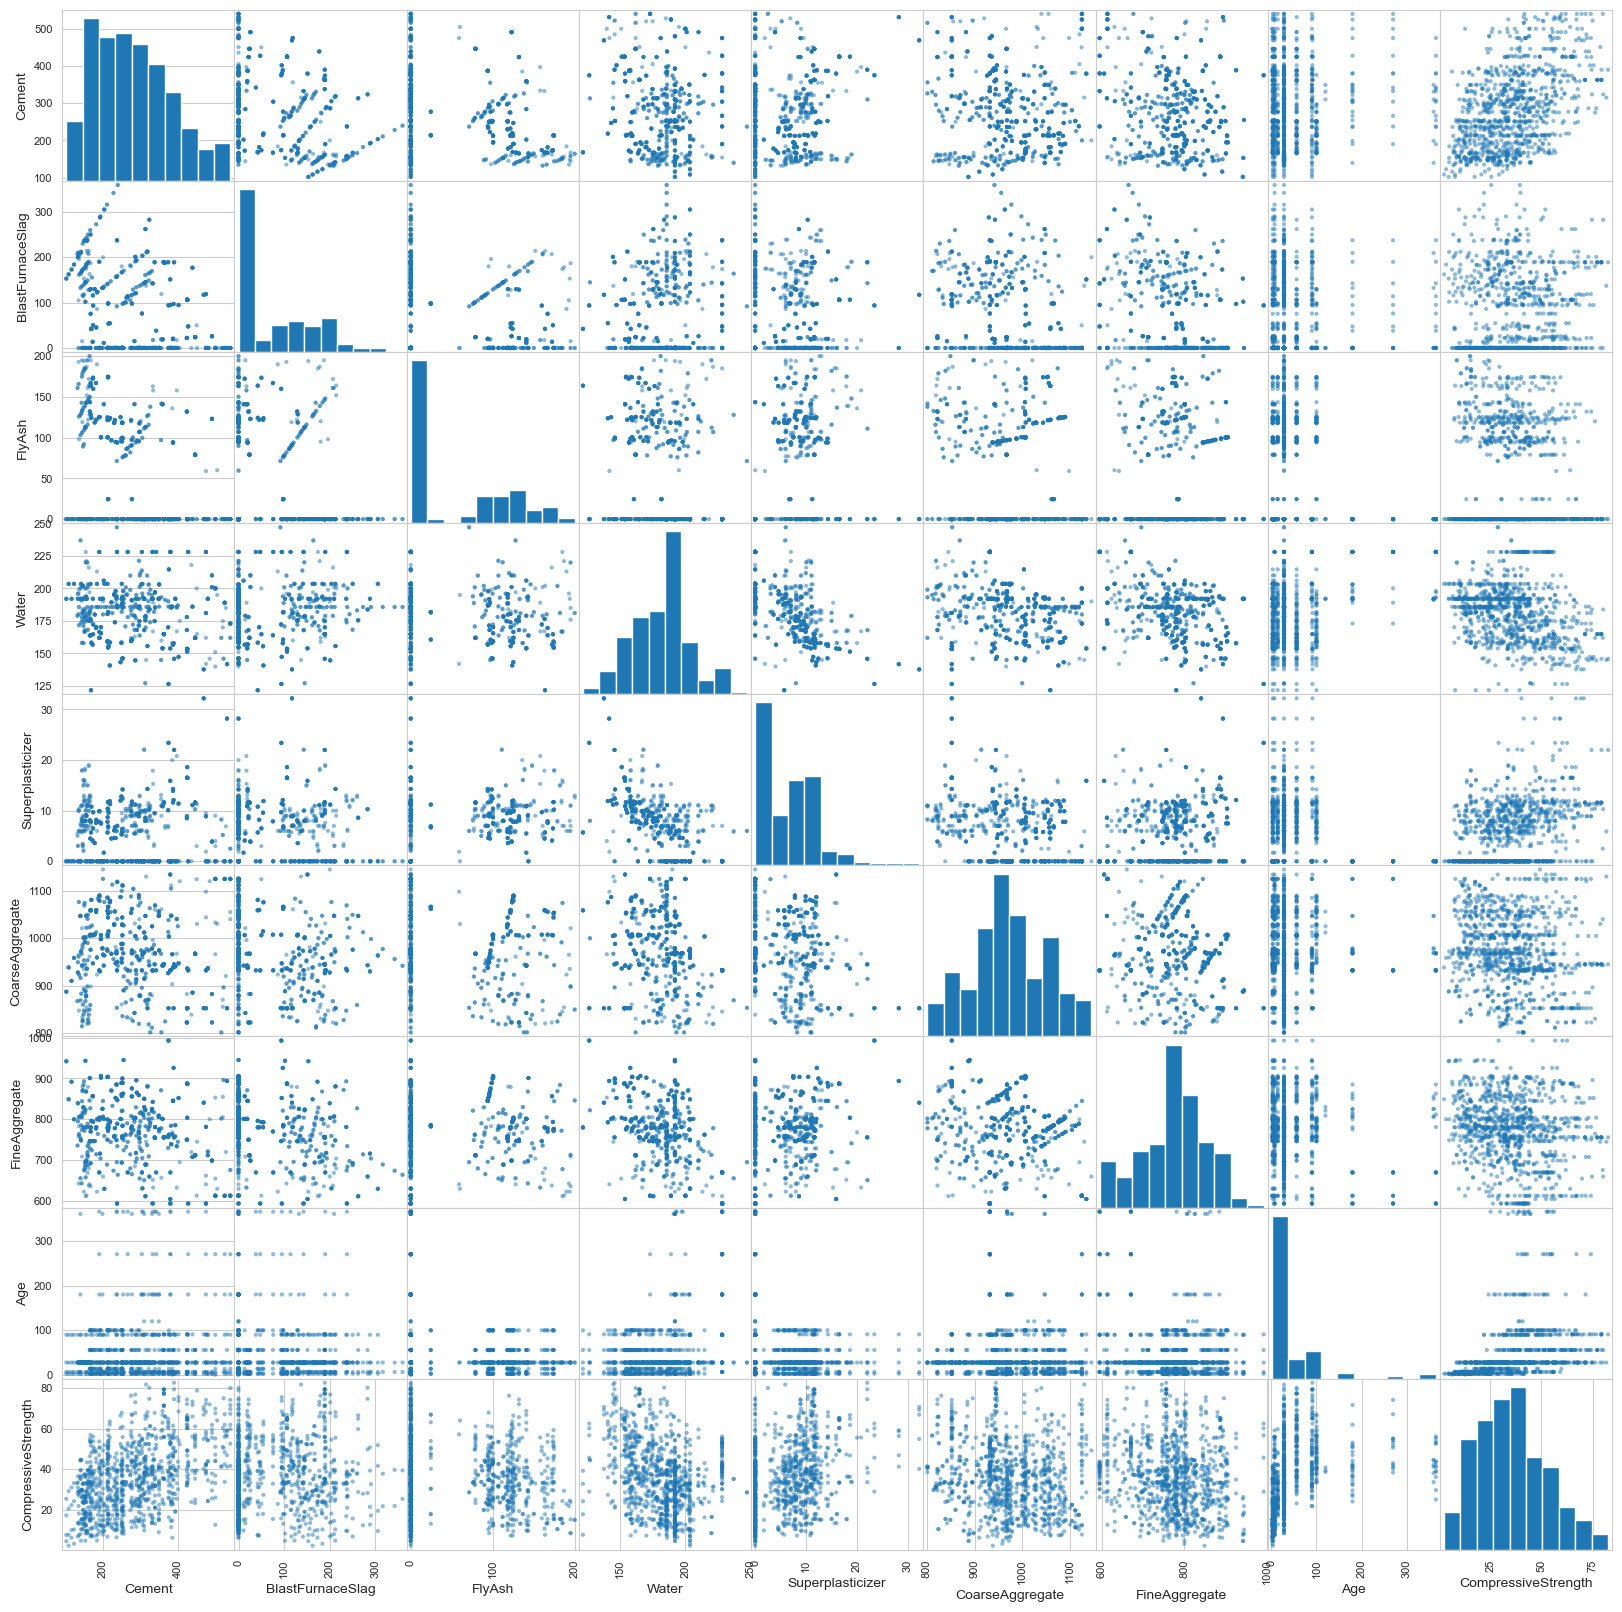

In [140]:
# draw matrix
scatter_matrix(df,figsize=(20,20));

#### 2. Use a heatmap to check for correlation between predictor variables

In [159]:
corr = df.corr()
corr

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
Cement,1.000000,-0.303324,-0.385610,-0.056625,0.060906,-0.086205,-0.245375,0.086348,0.488283
BlastFurnaceSlag,-0.303324,1.000000,-0.312352,0.130262,0.019800,-0.277559,-0.289685,-0.042759,0.103374
FlyAsh,-0.385610,-0.312352,1.000000,-0.283314,0.414213,-0.026468,0.090262,-0.158940,-0.080648
Water,-0.056625,0.130262,-0.283314,1.000000,-0.646946,-0.212480,-0.444915,0.279284,-0.269624
Superplasticizer,0.060906,0.019800,0.414213,-0.646946,1.000000,-0.241721,0.207993,-0.194076,0.344209
CoarseAggregate,-0.086205,-0.277559,-0.026468,-0.212480,-0.241721,1.000000,-0.162187,-0.005264,-0.144717
FineAggregate,-0.245375,-0.289685,0.090262,-0.444915,0.207993,-0.162187,1.000000,-0.156572,-0.186448
Age,0.086348,-0.042759,-0.158940,0.279284,-0.194076,-0.005264,-0.156572,1.000000,0.337367
CompressiveStrength,0.488283,0.103374,-0.080648,-0.269624,0.344209,-0.144717,-0.186448,0.337367,1.000000


<AxesSubplot: >

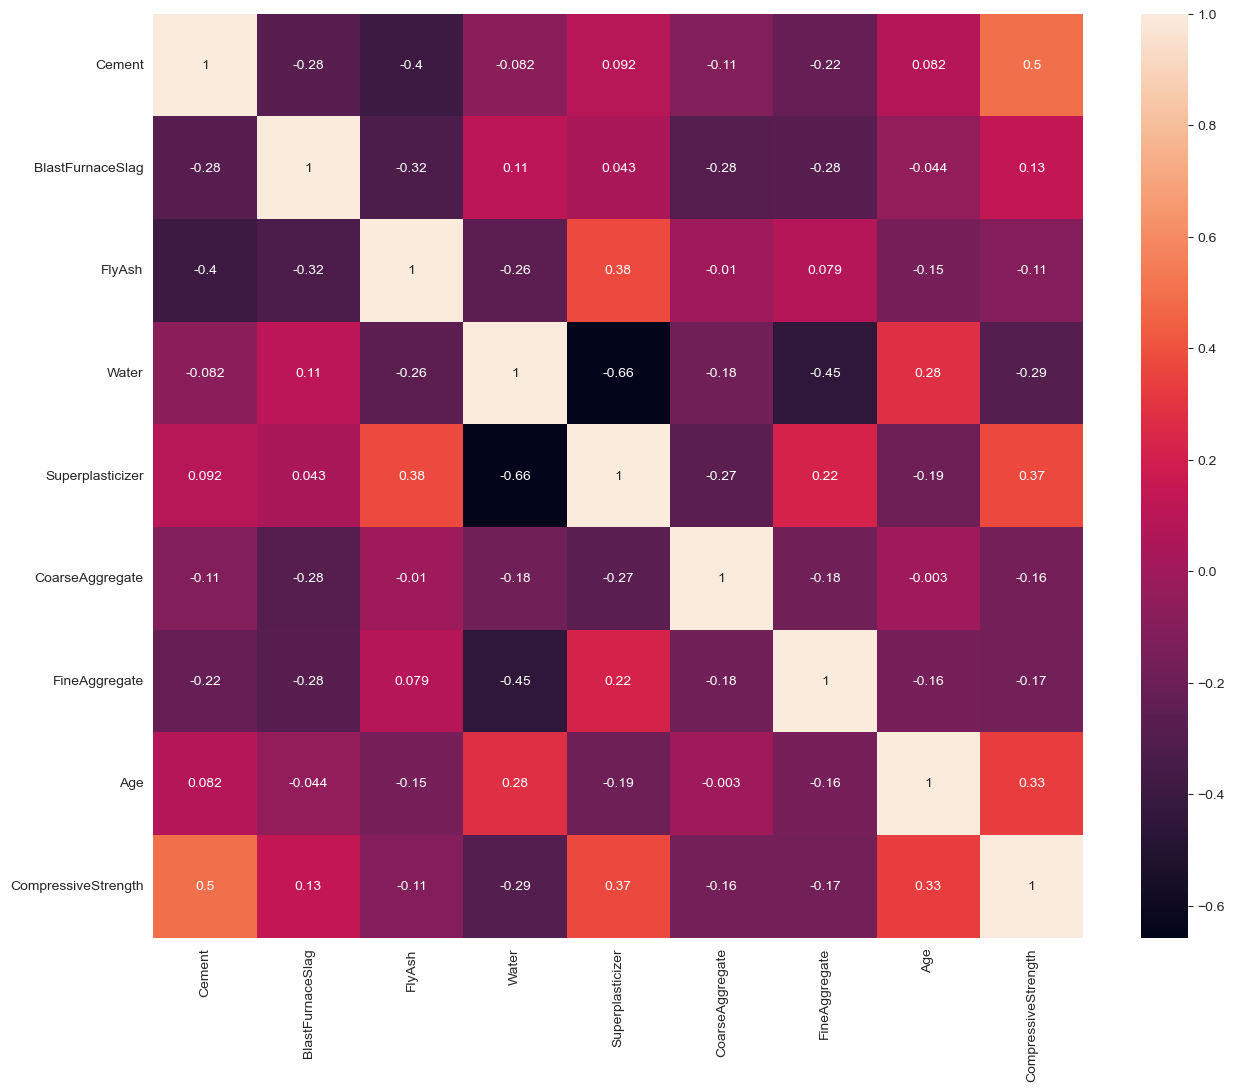

In [145]:
plt.figure(figsize=(15,12))
sns.heatmap(corr, annot = True)

## II. Feature Engineering

### Ensure data is in the correct format for downstream processes
#### Check for duplicates & missing values and drop, if present

In [149]:
# check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 Cement                 0
BlastFurnaceSlag       0
FlyAsh                 0
Water                  0
Superplasticizer       0
CoarseAggregate        0
FineAggregate          0
Age                    0
CompressiveStrength    0
dtype: int64


In [152]:
# check for deplicate values
print("Duplicates:\n", df.duplicated().sum())

Duplicates:
 25


In [153]:
# the shape of dataframe
df.shape

(1030, 9)

In [155]:
# drop duplicates
df = df.drop_duplicates()

In [156]:
# check the data shape
df.shape

(1005, 9)

There are 0 missing value and 25 duplicate values in the concrete dataset,  after drop the total data changed from 1030 rows to 1005 rows.

#### Remove possible outliners in the dataset

( I define the outliners as greater than 75%quartile add the 1.5 Interquatrile range and less than 25% quartile subtract the 1.5 Interquatrile range)

In [160]:
df.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,278.631343,72.043483,55.536318,182.075323,6.033234,974.376816,772.688259,45.856716,35.250378
std,104.344261,86.170807,64.207969,21.339334,5.919967,77.579667,80.340435,63.734692,16.284815
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,190.700000,0.000000,0.000000,166.600000,0.000000,932.000000,724.300000,7.000000,23.520000
50%,265.000000,20.000000,0.000000,185.700000,6.100000,968.000000,780.000000,28.000000,33.800000
75%,349.000000,142.500000,118.300000,192.900000,10.000000,1031.000000,822.200000,56.000000,44.870000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [161]:
from sklearn.preprocessing import QuantileTransformer
quantile  = QuantileTransformer()
X = quantile.fit_transform(df)
df=quantile.transform(X)
df=pd.DataFrame(X)
df.columns =['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water','Superplasticizer', 'CoarseAggregate','FineAggregate','Age','CompressiveStrength']
df.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,1.000000,0.000000,0.0,0.201702,0.384384,0.755756,0.135135,0.522022,0.997038
1,1.000000,0.000000,0.0,0.201702,0.384384,0.822322,0.135135,0.522022,0.934263
2,0.717718,0.752753,0.0,0.969970,0.000000,0.260761,0.000000,0.974474,0.648511
3,0.717718,0.752753,0.0,0.969970,0.000000,0.260761,0.000000,1.000000,0.667668
4,0.271271,0.723724,0.0,0.689690,0.000000,0.567568,0.764765,0.983984,0.736737


In [ ]:
# #BlastFurnaceSlag
# df=df[df['BlastFurnaceSlag']<(142.5+1.5*(142.5-0))]
# #Water
# df=df[df['Water']<(192.9+1.5*(192.9-166.6))]
# df=df[df['Water']>(166.6-1.5*(192.9-166.6))]
# #Superplasticizer
# df=df[df['Superplasticizer']<(10+1.5*(10-0))]
# #FineAggregate
# df=df[df['FineAggregate']<(822.2+1.5*(822.2-724.3))]
# #Age
# df=df[df['Age']<(56+1.5*(56-7))]
# #CompressiveStrength
# df=df[df['CompressiveStrength']<(44.87+1.5*(44.87-23.52))]

In [ ]:
plt.figure(figsize=(16,12))
sns.set_style(style='whitegrid')
plt.subplot(3,3,1)
sns.boxplot(x='Cement',data=df)
plt.subplot(3,3,2)
sns.boxplot(x='BlastFurnaceSlag',data=df)
plt.subplot(3,3,3)
sns.boxplot(x='FlyAsh',data=df)
plt.subplot(3,3,4)
sns.boxplot(x='Water',data=df)
plt.subplot(3,3,5)
sns.boxplot(x='Superplasticizer',data=df)
plt.subplot(3,3,6)
sns.boxplot(x='CoarseAggregate',data=df)
plt.subplot(3,3,7)
sns.boxplot(x='FineAggregate',data=df)
plt.subplot(3,3,8)
sns.boxplot(x='Age',data=df)
plt.subplot(3,3,9)
sns.boxplot(x='CompressiveStrength',data=df)

In [ ]:
df.describe()

#### 3. Check for zero in the dataset and impute with the mean

In [ ]:
#checking for 0 values in columns
print(df[df['Cement']==0].shape[0])
print(df[df['BlastFurnaceSlag']==0].shape[0])
print(df[df['FlyAsh']==0].shape[0])
print(df[df['Water']==0].shape[0])
print(df[df['Superplasticizer']==0].shape[0])
print(df[df['CoarseAggregate']==0].shape[0])
print(df[df['FineAggregate']==0].shape[0])
print(df[df['Age']==0].shape[0])
print(df[df['CompressiveStrength']==0].shape[0])

In [ ]:
df['Cement']=df['Cement'].replace(0,df['Cement'].mean())#normal distribution
df['Water']=df['Water'].replace(0,df['Water'].mean())#normal distribution
df['CoarseAggregate']=df['CoarseAggregate'].replace(0,df['CoarseAggregate'].mean())#normal distribution
df['FineAggregate']=df['FineAggregate'].replace(0,df['FineAggregate'].mean())#normal distribution
df['CompressiveStrength']=df['CompressiveStrength'].replace(0,df['CompressiveStrength'].mean())#normal distribution

Some of the columns have a skewed distribution, so the mean is more affected by outliers than the median

In [ ]:
df['BlastFurnaceSlag']=df['BlastFurnaceSlag'].replace(0,df['BlastFurnaceSlag'].median())#skewed distribution
df['FlyAsh']=df['FlyAsh'].replace(0,df['FlyAsh'].median())#skewed distribution
df['Superplasticizer']=df['Superplasticizer'].replace(0,df['Superplasticizer'].median())#skewed distribution
df['Age']=df['Age'].replace(0,df['Age'].median())#skewed distribution

In [ ]:
#checking for 0 values in 3 columns
print(df[df['Cement']==0].shape[0])
print(df[df['BlastFurnaceSlag']==0].shape[0])
print(df[df['FlyAsh']==0].shape[0])
print(df[df['Water']==0].shape[0])
print(df[df['Superplasticizer']==0].shape[0])
print(df[df['CoarseAggregate']==0].shape[0])
print(df[df['FineAggregate']==0].shape[0])
print(df[df['Age']==0].shape[0])
print(df[df['CompressiveStrength']==0].shape[0])